In [ ]:
# Scatter plot of age and columns of all sheets in data_shape and data_diffusion

# Last updated: 9/13/2020
# By: Zulfar Ghulam-Jelani

In [1]:
## Import libraries 
import pandas as pd
import csv
import numpy as np
import math
import statistics as st
import xlrd
from scipy import special
from scipy import stats
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.optimize import curve_fit

# pip install uncertainties, if needed
try:
    import uncertainties.unumpy as unp
    import uncertainties as unc
except:
    try:
        from pip import main as pipmain
    except:
        from pip._internal import main as pipmain
    pipmain(['install','uncertainties'])
    import uncertainties.unumpy as unp
    import uncertainties as unc

In [121]:
## Load variables
shape = pd.read_excel(r'./../data/2020_07_04 structural metrics/data_shape.xlsx', None)
diffusion = pd.read_excel(r'./../data/2020_07_04 structural metrics/data_diffusion.xlsx', None)
demo = pd.read_csv(r'./../data/2020_07_04 demo/demo.tsv',delimiter="\t")

# which sheet name you want
xls = xlrd.open_workbook(r'./../data/2020_07_04 structural metrics/data_shape.xlsx', on_demand=True)
sheet_name = xls.sheet_names() 
sheet_num = 17                                               #change from 0 to 17 to run for each sheet 
sheet = sheet_name[sheet_num]        

# Column names
col_S = list(shape[sheet])
col_D = list(diffusion[sheet])
col_d = list(demo.columns)


# Choose specific sheet  # NEED TO FIGURE OUT HOW TO DO THIS FOR ALL SHEETS AUTOMATICALLY 
shape_array = pd.DataFrame.to_numpy(shape[sheet])  
diffusion_array = pd.DataFrame.to_numpy(diffusion[sheet])   
demo_array = pd.DataFrame.to_numpy(demo)

In [122]:
## Combine Age Information for SHAPE
demo_S = np.empty((0,len(demo_array[0,:])),object)

# find shape subjects 
for x in range(0, len(demo_array[:,0])):
    for y in range(0,len(shape_array[:,0])):
        if demo_array[x,0] in shape_array[y,0]:            
            result = demo_array[x,:]
            demo_S = np.append(demo_S,[result],axis=0)

# Demo information keeping 
demo_S = demo_S[:,1]            #only age included 
col_d = ['age']

In [123]:
## Combine Age Information for DIFFUSION
demo_D = np.empty((0,len(demo_array[0,:])),object)

# find diffusion subjects 
for x in range(0, len(demo_array[:,0])):
    for y in range(0,len(diffusion_array[:,0])):
        if demo_array[x,0] in diffusion_array[y,0]:            
            result = demo_array[x,:]
            demo_D = np.append(demo_D,[result],axis=0)

# Demo information keeping 
demo_D = demo_D[:,1]            #only age included 
col_d = ['age']

In [124]:
## Remove Outliers for SHAPE 
# outlier removal routine to remove outliers for each structure metrics. 
# To avoid the age factor in outlier removal, will divide age population 
# into four pools, and apply outlier removal separately.

# Find age group
age = demo_array[:,1]                                     
maxAge = max(age)
minAge = min(age)
bins = maxAge - minAge
pool = math.ceil(bins/4)

# Sort variables by age for shape 
shape_all = np.append(shape_array,demo_S[:,None],axis=1)                    #combine the age information with the data 
col_allS = np.append(col_S,col_d)                                            #columns 
ind = [i for i, s in enumerate(col_allS) if 'age' in s]                      #find the age column
ind = ind[0]
shape_sorted = shape_all[shape_all[:,ind].argsort()]                        #sort by age 

# Make 4 pools based on age for shape 
shapeP1 = shape_sorted[(shape_sorted[:,ind] <= minAge + 1*pool),:]
shapeP2 = shape_sorted[(shape_sorted[:,ind] <= minAge + 2*pool) & (shape_sorted[:,ind] > minAge + 1*pool),:]
shapeP3 = shape_sorted[(shape_sorted[:,ind] <= minAge + 3*pool) & (shape_sorted[:,ind] > minAge + 2*pool),:]
shapeP4 = shape_sorted[(shape_sorted[:,ind] <= minAge + 4*pool) & (shape_sorted[:,ind] > minAge + 3*pool),:]

# Remove outliers 
# Outliers are defined as elements more than three scaled MAD from the median. The scaled MAD is defined as c*median(abs(A-median(A))), where c=-1/(sqrt(2)*erfcinv(3/2)).
c = -1/ (math.sqrt(2)*special.erfcinv(3/2))
for x in range(0,4):
    for y in range(0,len(shape_sorted[0,:])):
        #iterating thru the 4 pools that are based on age
        if(x == 0):
            A = shapeP1[:,y]
        elif(x == 1):
            A = shapeP2[:,y]
        elif(x == 2):
            A = shapeP3[:,y]
        elif(x == 3):
            A = shapeP4[:,y]
            
        if(isinstance(A[0],str) == True):            #if string, avoid 
            continue
        elif(isinstance(A[0],str) == False):         #if not string, remove outliers 
            MAD = c*st.median((abs(A-st.median(A))))
            ind2 = [idx for idx, val in enumerate(A) if val > (MAD*3+st.median(A))] 
            
            if ind2:                                                      #checking if not empty array
                if(x == 0):                                               #deleting specific indices 
                    shapeP1 = np.delete(shapeP1,ind2,0)
                elif(x == 1):
                    shapeP2 = np.delete(shapeP2,ind2,0)
                elif(x == 2):
                    shapeP3 = np.delete(shapeP3,ind2,0)
                elif(x == 3):
                    shapeP4 = np.delete(shapeP4,ind2,0)
            elif not ind2:                                                #checking if empty array: do nothing 
                continue
shapeAll = np.append(shapeP1,shapeP2,axis=0)
shapeAll = np.append(shapeAll,shapeP3,axis=0)
shapeAll = np.append(shapeAll,shapeP4,axis=0)

In [125]:
## Remove Outliers for DIFFUSION 
# outlier removal routine to remove outliers for each structure metrics. 
# To avoid the age factor in outlier removal, will divide age population 
# into four pools, and apply outlier removal separately.

# Sort variables by age for diffusion 
diffusion_all = np.append(diffusion_array,demo_D[:,None],axis=1)            #combine the age information with the data 
col_allD = np.append(col_D,col_d)                                            #columns 
ind = [i for i, s in enumerate(col_allD) if 'age' in s]                      #find the age column
ind = ind[0]
diffusion_sorted = diffusion_all[diffusion_all[:,ind].argsort()]                #sort by age 

# Make 4 pools based on age for shape 
diffusionP1 = diffusion_sorted[(diffusion_sorted[:,ind] <= minAge + 1*pool),:]
diffusionP2 = diffusion_sorted[(diffusion_sorted[:,ind] <= minAge + 2*pool) & (diffusion_sorted[:,ind] > minAge + 1*pool),:]
diffusionP3 = diffusion_sorted[(diffusion_sorted[:,ind] <= minAge + 3*pool) & (diffusion_sorted[:,ind] > minAge + 2*pool),:]
diffusionP4 = diffusion_sorted[(diffusion_sorted[:,ind] <= minAge + 4*pool) & (diffusion_sorted[:,ind] > minAge + 3*pool),:]

# Remove outliers 
# Outliers are defined as elements more than three scaled MAD from the median. The scaled MAD is defined as c*median(abs(A-median(A))), where c=-1/(sqrt(2)*erfcinv(3/2)).
c = -1/ (math.sqrt(2)*special.erfcinv(3/2))
for x in range(0,4):
    for y in range(0,len(diffusion_sorted[0,:])):
        #iterating thru the 4 pools that are based on age
        if(x == 0):
            A = diffusionP1[:,y]
        elif(x == 1):
            A = diffusionP2[:,y]
        elif(x == 2):
            A = diffusionP3[:,y]
        elif(x == 3):
            A = diffusionP4[:,y]
            
        if(isinstance(A[0],str) == True):            #if string, avoid 
            continue
        elif(isinstance(A[0],str) == False):         #if not string, remove outliers 
            MAD = c*st.median((abs(A-st.median(A))))
            ind2 = [idx for idx, val in enumerate(A) if val > (MAD*3+st.median(A))] 
            
            if ind2:                                                      #checking if not empty array
                if(x == 0):                                               #deleting specific indices 
                    diffusionP1 = np.delete(diffusionP1,ind2,0)
                elif(x == 1):
                    diffusionP2 = np.delete(diffusionP2,ind2,0)
                elif(x == 2):
                    diffusionP3 = np.delete(diffusionP3,ind2,0)
                elif(x == 3):
                    diffusionP4 = np.delete(diffusionP4,ind2,0)
            elif not ind2:                                                #checking if empty array: do nothing 
                continue
diffusionAll = np.append(diffusionP1,diffusionP2,axis=0)
diffusionAll = np.append(diffusionAll,diffusionP3,axis=0)
diffusionAll = np.append(diffusionAll,diffusionP4,axis=0)

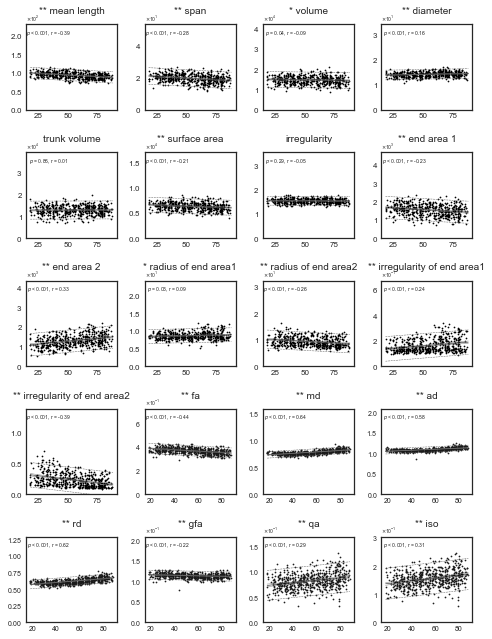

In [126]:
## Scatter Plot 

# Confidence intervals 
def predband(x, xd, yd, p, func, conf=0.95):
            # x = requested points
            # xd = x data
            # yd = y data
            # p = parameters
            # func = function name
            alpha = 1.0 - conf                                             # significance
            N = xd.size                                                    # data sample size
            var_n = len(p)                                                 # number of parameters
            # Quantile of Student's t distribution for p=(1-alpha/2)
            q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
            # Stdev of an individual measurement
            se = np.sqrt(1. / (N - var_n) * \
                         np.sum((yd - func(xd, *p)) ** 2))
            # Auxiliary definitions
            sx = (x - xd.mean()) ** 2
            sxd = np.sum((xd - xd.mean()) ** 2)
            # Predicted values (best-fit model)
            yp = func(x, *p)
            # Prediction band
            dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
            # Upper & lower prediction bands.
            lpb, upb = yp - dy, yp + dy
            return lpb, upb
        
# create subplot 
with plt.style.context("seaborn-white"):
    fig, axs = plt.subplots(5,4,figsize=(8,11))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    axs = axs.ravel()
    
    
    # data 
    data = pd.DataFrame(shapeAll,columns=col_allS)
    y_colS = col_allS[1:-1]
    data = data.drop("curl", axis=1);            y_colS = y_colS[y_colS != 'curl']              #remove curl
    data = data.drop("elongation", axis=1);      y_colS = y_colS[y_colS != 'elongation']        #remove elongation
    
    # Make array to save r-values and p-values  
    rvals_S = np.zeros(len(y_colS))
    pvals_S = np.zeros(len(y_colS))
    
    # Plots for Shape 
    for i in range(0,len(y_colS)):
        x = data['age'].values
        y = data[y_colS[i]].values
        n = len(y)

        def f(x, a, b):
            return a * x + b

        popt, pcov = curve_fit(f, x, y)

        # retrieve parameter values
        a = popt[0]
        b = popt[1]

        # compute r^2
        r2 = 1.0-(sum((y-f(x,a,b))**2)/((n-1.0)*np.var(y,ddof=1)))
        #print('R^2: ' + str(r2))

        # calculate parameter confidence interval
        a,b = unc.correlated_values(popt, pcov)

        # plot data
        axs[i].scatter(x, y, s=0.5, color = 'black', label='Data')

        # calculate regression confidence interval
        px = np.linspace(minAge, maxAge, 100)
        py = a*px+b
        nom = unp.nominal_values(py)
        std = unp.std_devs(py)
        lpb, upb = predband(px, x, y, popt, f, conf=0.95)

        # plot the regression
        axs[i].plot(px, nom, c='black', label='y=a x + b', linewidth=0.5)

        # uncertainty lines (95% confidence)
        axs[i].plot(px, nom - 1.96 * std, c='gray', label='95% Confidence Region', linewidth=0.5)
        axs[i].plot(px, nom + 1.96 * std, c='gray', linewidth=0.5)
        # prediction band (95% confidence)
        axs[i].plot(px, lpb, color='#646464', linestyle='--', label='95% Prediction Band', linewidth=0.5)
        axs[i].plot(px, upb, color='#646464', linestyle='--', linewidth=0.5)
        
        # remove the parenthesis with units
        s = y_colS[i]
        ind = s.find("(")
        if ind != -1:
            Title = s[:ind]
        else:
            Title = y_colS[i]
        
        #replace "dti_fa" by "fa"
        if Title == 'dti_fa':
            Title = 'fa'     
        
        #set y limits 
        axs[i].set_ylim(bottom=0)
        if min(y)==0:
            axs[i].set_ylim(top=2*max(y))
        else:
            axs[i].set_ylim(top=max(y)+max(y))
            
        #find p-values 
        coef, p = spearmanr(x,y)
        if p < 0.001:
            plt.text(0.25, 0.9, '$\it{p}$ < 0.001, r = %.2f'%coef, horizontalalignment='center', verticalalignment='center', fontsize=5, transform=axs[i].transAxes)
            # title 
            axs[i].set_title('** %s'%Title,fontsize=10) 
            ttl = axs[i].title
            ttl.set_position([.5, 1.05]) 
        elif p < 0.05:
            plt.text(0.25, 0.9, '$\it{p}$ = %.2f, r = %.2f'%(p,coef), horizontalalignment='center', verticalalignment='center', fontsize=5, transform=axs[i].transAxes)
            # title 
            axs[i].set_title('* %s'%Title,fontsize=10) 
            ttl = axs[i].title
            ttl.set_position([.5, 1.05]) 
        elif p >= 0.05:
            plt.text(0.25, 0.9, '$\it{p}$ = %.2f, r = %.2f'%(p,coef), horizontalalignment='center', verticalalignment='center', fontsize=5, transform=axs[i].transAxes)
            # title 
            axs[i].set_title(Title,fontsize=10) 
            ttl = axs[i].title
            ttl.set_position([.5, 1.05]) 
        
        #Save the r-values and p-values
        rvals_S[i] = coef
        pvals_S[i] = p
        
        #Scientific notation for y axis 
        from matplotlib import ticker
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 
        axs[i].yaxis.offsetText.set_fontsize(5)
        axs[i].yaxis.set_major_formatter(formatter) 
        axs[i].get_yaxis().get_offset_text().set_position((0,0.5))         #location
        
        #axis tick font size 
        axs[i].tick_params(axis='both', which='major', labelsize=8)


        
        
        
    # data 
    data = pd.DataFrame(diffusionAll,columns=col_allD)
    y_colD = col_allD[1:-1]
    data = data.drop("nqa", axis=1);      y_colD = y_colD[y_colD != 'nqa']        #remove nqa

    # Make array to save r-values and p-values
    rvals_D = np.zeros(len(y_colD))
    pvals_D = np.zeros(len(y_colD))
        
    # change order of data (move qa to the place between gfa and iso)
    cols = list(data.columns.values) #Make a list of all of the columns in data
    cols.pop(cols.index('qa'))       #Remove qa from list
    cols.pop(cols.index('iso'))      #Remove iso from list 
    cols.pop(cols.index('age'))      #Remove age from list
    data = data[cols+['qa','iso','age']]   #Create new dataframe with columns in the order you want
    y_colD = list(data.columns.values)
    y_colD = y_colD[1:-1]
    
    # Plots for Diffusion
    for j in range(len(y_colS),(len(y_colS)+len(y_colD))):
        x = data['age'].values
        y = data[y_colD[j-len(y_colS)]].values
        n = len(y)

        def f(x, a, b):
            return a * x + b

        popt, pcov = curve_fit(f, x, y)

        # retrieve parameter values
        a = popt[0]
        b = popt[1]

        # compute r^2
        r2 = 1.0-(sum((y-f(x,a,b))**2)/((n-1.0)*np.var(y,ddof=1)))

        # calculate parameter confidence interval
        a,b = unc.correlated_values(popt, pcov)

        # plot data
        axs[j].scatter(x, y, s=0.5, label='Data',color='k')

        # calculate regression confidence interval
        px = np.linspace(minAge, maxAge, 100)
        py = a*px+b
        nom = unp.nominal_values(py)
        std = unp.std_devs(py)
        lpb, upb = predband(px, x, y, popt, f, conf=0.95)

        # plot the regression
        axs[j].plot(px, nom, c='black', label='y=a x + b', linewidth=0.5)

        # uncertainty lines (95% confidence)
        axs[j].plot(px, nom - 1.96 * std, c='gray', label='95% Confidence Region', linewidth=0.5)
        axs[j].plot(px, nom + 1.96 * std, c='gray', linewidth=0.5)
        # prediction band (95% confidence)
        axs[j].plot(px, lpb, color='#646464', linestyle='--', label='95% Prediction Band', linewidth=0.5)
        axs[j].plot(px, upb, color='#646464', linestyle='--', linewidth=0.5)
        
        # remove the parenthesis with units
        s = y_colD[j-len(y_colS)]
        ind = s.find("(")
        if ind != -1:
            Title = s[:ind]
        else:
            Title = y_colD[j-len(y_colS)]
    
        #replace "dti_fa" by "fa"
        if Title == 'dti_fa':
            Title = 'fa'
        
        #set y limits 
        axs[j].set_ylim(bottom=0)
        if min(y)==0:
            axs[j].set_ylim(top=2*max(y))
        else:
            axs[j].set_ylim(top=min(y)+max(y))
        
        #find p-values 
        coef, p = spearmanr(x,y)
        if p < 0.001:
            plt.text(0.25, 0.9, '$\it{p}$ < 0.001, r = %.2f'%coef, horizontalalignment='center', verticalalignment='center', fontsize=5, transform=axs[j].transAxes)
            # title 
            axs[j].set_title('** %s'%Title,fontsize=10) 
            ttl = axs[j].title
            ttl.set_position([.5, 1.05])  
        elif p < 0.05:
            plt.text(0.25, 0.9, '$\it{p}$ = %.2f, r = %.2f'%(p,coef), horizontalalignment='center', verticalalignment='center', fontsize=5, transform=axs[j].transAxes)
            # title 
            axs[j].set_title('* %s'%Title,fontsize=10) 
            ttl = axs[j].title
            ttl.set_position([.5, 1.05]) 
        elif p >= 0.05:
            plt.text(0.25, 0.9, '$\it{p}$ = %.2f, r = %.2f'%(p,coef), horizontalalignment='center', verticalalignment='center', fontsize=5, transform=axs[j].transAxes)
            # title 
            axs[j].set_title(Title,fontsize=10) 
            ttl = axs[j].title
            ttl.set_position([.5, 1.05]) 
        
        #Save the r-values 
        rvals_D[j-len(y_colS)] = coef
        pvals_D[j-len(y_colS)] = p
        
        #Scientific notation for y axis 
        from matplotlib import ticker
        formatter = ticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 
        axs[j].yaxis.offsetText.set_fontsize(5)
        axs[j].yaxis.set_major_formatter(formatter) 
        axs[j].get_yaxis().get_offset_text().set_position((0,0.5))         #location
        
        #axis tick font size 
        axs[j].tick_params(axis='both', which='major', labelsize=7)
        
# Save figure
filename = "%s.tiff" % sheet
plt.savefig('Scatter_Plots/' + filename, format='tiff',dpi=300)

In [127]:
# Save r-values 
y_columns = np.append(y_colS,y_colD,axis=0)
rvals = np.append(rvals_S,rvals_D,axis=0)

if sheet_num == 0:
    rvalues = np.zeros((20,18))                  #18 is how many sheets there are, 20 is how many rows  
    rvalues[:,sheet_num] = rvals
else:
    rvalues[:,sheet_num] = rvals


# Save p-values
pvals = np.append(pvals_S,pvals_D,axis=0)

if sheet_num == 0:
    pvalues = np.zeros((20,18))                  #18 is how many sheets there are, 20 is how many rows 
    pvalues[:,sheet_num] = pvals
else:
    pvalues[:,sheet_num] = pvals

In [129]:
## Run at end after running each sheet_num

# Save r-values 
r_df = pd.DataFrame(rvalues, columns=sheet_name,index=y_columns)
filename = 'stats_r.xlsx'
r_df.to_excel(filename, sheet_name='r values')

# Save p-values 
p_df = pd.DataFrame(pvalues, columns=sheet_name,index=y_columns)
filename = 'stats_p.xlsx'
p_df.to_excel(filename, sheet_name='p values')